In [14]:
import csv
import json
import uuid
from pathlib import Path
from datetime import datetime, UTC

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer


In [15]:
BASE_DIR = Path("experiments")
BASE_DIR.mkdir(exist_ok=True)

CSV_PATH = BASE_DIR / "experiments.csv"
JSON_PATH = BASE_DIR / "experiments.json"

COLUMN_NAMES = [
    "experiment_id",
    "timestamp",
    "model",
    "parameters",
    "accuracy",
    "precision",
    "recall",
    "f1_score",
    "notes"
]

# Initialize CSV safely
if not CSV_PATH.exists() or CSV_PATH.stat().st_size == 0:
    with open(CSV_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(COLUMN_NAMES)

# Initialize JSON safely
if not JSON_PATH.exists():
    with open(JSON_PATH, "w") as f:
        json.dump([], f)


In [16]:
texts = [
    "I feel happy and confident",
    "I am calm and relaxed",
    "I feel stressed and overwhelmed",
    "I feel sad and unmotivated",
    "I feel neutral today",
    "I am anxious about work",
    "I feel excited and positive"
]

# 0 = negative, 1 = neutral, 2 = positive
labels = np.array([2, 2, 0, 0, 1, 0, 2])


In [33]:
def run_experiment(
    model_name: str,
    model,
    vectorizer,
    test_size=0.2,
    notes=""
):
    experiment_id = str(uuid.uuid4())
    timestamp = datetime.now(UTC).isoformat()

    X = vectorizer.fit_transform(texts)
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, average="weighted", zero_division=0
    )

    record = {
        "experiment_id": experiment_id,
        "timestamp": timestamp,
        "model": model_name,
        "parameters": model.get_params(),
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "notes": notes
    }

    # Append CSV
    with open(CSV_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            experiment_id,
            timestamp,
            model_name,
            json.dumps(model.get_params()),
            acc,
            precision,
            recall,
            f1,
            notes
        ])

    # Append JSON safely
    with open(JSON_PATH, "r") as f:
        data = json.load(f)

    data.append(record)

    with open(JSON_PATH, "w") as f:
        json.dump(data, f, indent=2)

    return record


In [34]:
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words="english"
)

model = LogisticRegression(max_iter=1000)

result = run_experiment(
    model_name="LogisticRegression_TFIDF",
    model=model,
    vectorizer=vectorizer,
    notes="Baseline TF-IDF + Logistic Regression"
)

result


{'experiment_id': '82b60e1b-3677-4da9-91da-ff22b89d3cf8',
 'timestamp': '2026-01-07T16:56:54.465971+00:00',
 'model': 'LogisticRegression_TFIDF',
 'parameters': {'C': 1.0,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'l1_ratio': 0.0,
  'max_iter': 1000,
  'n_jobs': None,
  'penalty': 'deprecated',
  'random_state': None,
  'solver': 'lbfgs',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False},
 'accuracy': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'notes': 'Baseline TF-IDF + Logistic Regression'}

In [35]:
df = pd.read_csv(CSV_PATH)

# Force correct headers (handles legacy files safely)
df.columns = COLUMN_NAMES

df.sort_values("timestamp", ascending=False)


,experiment_id,timestamp,model,parameters,accuracy,precision,recall,f1_score,notes
8,82b60e1b-3677-4da9-91da-ff22b89d3cf8,2026-01-07T16:56:54.465971+00:00,LogisticRegression_TFIDF,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Baseline TF-IDF + Logistic Regression
7,eaa0dd1c-c40a-45b9-8146-a58549eb4d7d,2026-01-07T16:56:36.591775+00:00,LogReg_TFIDF_small_features,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Reduced features
6,e62686b7-0024-4fd6-943f-1c7e69d39322,2026-01-07T16:56:32.740120+00:00,LogReg_TFIDF_bigram,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Added bigrams
5,20ed6943-eed0-4c8e-a01a-ca522f0eb685,2026-01-07T16:56:24.267494+00:00,LogReg_TFIDF_default,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Baseline
4,b76b029e-5451-4afd-9db7-ea2192c2283a,2026-01-07T16:56:15.251724+00:00,LogReg_TFIDF_small_features,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Reduced features
3,a2374e12-54d3-4f39-9aee-70abb97314d4,2026-01-07T16:56:15.228481+00:00,LogReg_TFIDF_bigram,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Added bigrams
2,0609692f-e158-4a71-bf99-4f093b3f4209,2026-01-07T16:56:15.193556+00:00,LogReg_TFIDF_default,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Baseline
1,61986f3f-87fb-4525-8dd4-957f1fd885db,2026-01-07T16:54:32.588022+00:00,LogReg_TFIDF_500,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Reduced max_features and max_iter
0,ab06b68f-5026-44ea-a18f-5bf050d088da,2026-01-07T16:50:22.176705+00:00,LogisticRegression_TFIDF,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Baseline TF-IDF + Logistic Regression


In [36]:
metric_cols = ["accuracy", "precision", "recall", "f1_score"]

for col in metric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df[metric_cols].dtypes


accuracy     float64
precision    float64
recall       float64
f1_score     float64
dtype: object

In [37]:
df_plot = df.set_index("experiment_id")


In [38]:
if len(df_plot) < 2:
    print("⚠️ Run at least 2 experiments to see a comparison plot.")


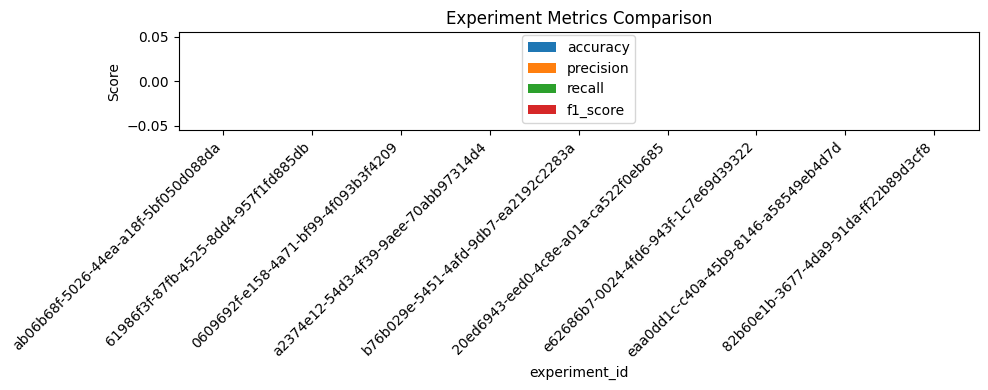

In [39]:
import matplotlib.pyplot as plt

df_plot[["accuracy", "precision", "recall", "f1_score"]].plot(
    kind="bar",
    figsize=(10, 4),
    title="Experiment Metrics Comparison"
)

plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [27]:
print("Total experiments:", len(df))
print("Best accuracy:", df["accuracy"].max())
print("Latest experiment:")
df.tail(1)


Total experiments: 1
Best accuracy: 0.0
Latest experiment:


,experiment_id,timestamp,model,parameters,accuracy,precision,recall,f1_score,notes
0,ab06b68f-5026-44ea-a18f-5bf050d088da,2026-01-07T16:50:22.176705+00:00,LogisticRegression_TFIDF,"{""C"": 1.0, ""class_weight"": null, ""dual"": false...",0.0,0.0,0.0,0.0,Baseline TF-IDF + Logistic Regression
